In [1]:
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [3]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [10]:
bed_allpeaks = "/data2st1/junyi/output/atac0416/cCRE/peak.bed"
bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"

merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [11]:
len(merged), len(non_overlapping)

(295713, 1534765)

In [12]:
bedall_peaks = BedTool(bed_allpeaks)

In [13]:
len(bedall_peaks)

1371000

In [8]:
bed_intron = "/data2st1/junyi/generegion_vM33/intron.bed"

intron, non_intron = intersect_bed_files(bed_allpeaks, bed_intron)

df_intron = intron.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])

num_intron = len(df_intron)

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron



In [9]:
df_intron.to_csv("/data2st1/junyi/output/cCRE/ALL_sampled_peaks_intron.bed", sep="\t", index=False)

In [42]:
bed_intron = "/data2st1/junyi/generegion_vM33/exon.bed"
exon = BedTool(bed_intron)
exon, non_ie = intersect_bed_objects(non_intron, exon)


***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon

***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon

***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon

***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon



In [92]:
df_exon = exon.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_exon = len(df_exon)

In [93]:
promoter = BedTool("/data2st1/junyi/generegion_vM33/promoter.bed")
promoter, non_iep = intersect_bed_objects(non_ie, promoter)
df_promoter = promoter.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_promoter = len(df_promoter)

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter



In [94]:
SINES = BedTool("/data2st1/junyi/generegion_vM33/sines.bed")
SINES, non_sines = intersect_bed_files(non_iep, SINES)
df_sines = SINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_sines = len(df_sines)

In [95]:
LTRS = BedTool("/data2st1/junyi/generegion_vM33/ltrs.bed")
LTRS, non_LTRS = intersect_bed_files(non_iep, LTRS)
df_ltrs = LTRS.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_ltrs = len(df_ltrs)

In [96]:
LINES = BedTool("/data2st1/junyi/generegion_vM33/lines.bed")
LINES, non_LINES = intersect_bed_files(non_iep, LINES)
df_lines = LINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_lines = len(df_lines)


In [97]:
intergenic = '/data2st1/junyi/generegion_vM33/intergenic.bed'
intergenic, non_intergenic = intersect_bed_files(bed_allpeaks, intergenic)
df_intergenic = intergenic.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_intergenic = len(df_intergenic)

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic



In [98]:
other_repeat = '/data2st1/junyi/generegion_vM33/other_repeats.bed'
other_repeat, non_other_repeat = intersect_bed_files(non_iep, other_repeat)
df_other_repeat = other_repeat.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_other_repeat = len(df_other_repeat)

In [99]:
cpgi = '/data2st1/junyi/generegion_vM33/cpg.bed'
cpgi, non_cpgi = intersect_bed_files(bed_allpeaks, cpgi)
df_cpgi = cpgi.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_cpgi = len(df_cpgi)

In [100]:
num_cpgi

19364

In [ ]:
import seaborn as sns

data = {'Region': ['Intron', 'Exon', 'Promoter', 'SINES', 'LTRs', 'LINES', 'Intergenic', 'Other Repeats', 'CpG Islands'],
        'Number of Peaks': [num_intron, num_exon, num_promoter, num_sines, num_ltrs, num_lines, num_intergenic, num_other_repeat, num_cpgi]}
df = pd.DataFrame(data)


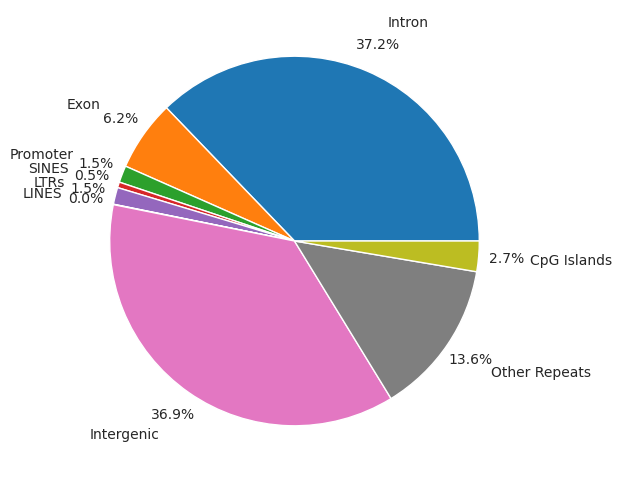

In [114]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df['Number of Peaks'], labels=df['Region'], autopct='%1.1f%%',pctdistance=1.15,labeldistance=1.28)
plt.show()


In [116]:
import subprocess
filename= '/data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed'
command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed"
print(command_str)
subprocess.run(command_str, shell=True)

/home/junyichen/liftOver /data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed


Reading liftover chains
Mapping coordinates


CompletedProcess(args='/home/junyichen/liftOver /data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed', returncode=0)

In [117]:
bed_allpeaks = "/data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed"
bed_encode = "/data2st1/junyi/output/convert_enhancer.bed"

merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [124]:
merged.saveas("/data2st1/junyi/output/cCRE/merged_mm10.bed")
non_overlapping.saveas("/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed")

<BedTool(/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed)>

In [122]:
import pyBigWig

# 打开 bigWig 文件
bw = pyBigWig.open("/data2st1/junyi/phascon/mm10.60way.phastCons.bw")

In [128]:
line.strip().split('\t')

['chr1', '3119734', '3120235', 'chr1', '3119617', '3119911', '.', '.', 'dELS']

In [129]:
import numpy as np
scores_list = []
with open("/data2st1/junyi/output/cCRE/merged_mm10.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end, name,_,_,_,_,_ = line.strip().split('\t')
        start = int(start)
        end = int(end)
        summit = (start +
                  end) // 2
        

        # 获取 PhastCons 分数
        scores = bw.values(chrom, summit -250, summit + 250)
        scores = [score for score in scores if score is not None]

        # 计算平均分数
        # mean_score = np.mean(scores)
        # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
        scores_list.append(scores)


In [ ]:
scores_array = np.array(scores_list)
scores_array = np.nan_to_num(scores_array)
mean_value = np.mean(scores_array, axis=0)


In [ ]:
line

'chr1\t3012484\t3012985\n'

In [170]:
line

'chrUn_GL456393\t0\t476\n'

In [171]:
scores_list_non = []

with open("/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end= line.strip().split('\t')
        start = int(start)
        end = int(end)
        summit = (start +
                  end) // 2
        

        # 获取 PhastCons 分数
        try:
            scores = bw.values(chrom, summit -250, summit + 250)
            scores = [score for score in scores if score is not None]
        except:
            continue    
        # 计算平均分数
        # mean_score = np.mean(scores)
        # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
        scores_list_non.append(scores)


In [172]:
scores_array_non = np.array(scores_list_non)
scores_array_non = np.nan_to_num(scores_array_non)
mean_value_non = np.mean(scores_array_non, axis=0)

In [177]:
sns.set_style("whitegrid")


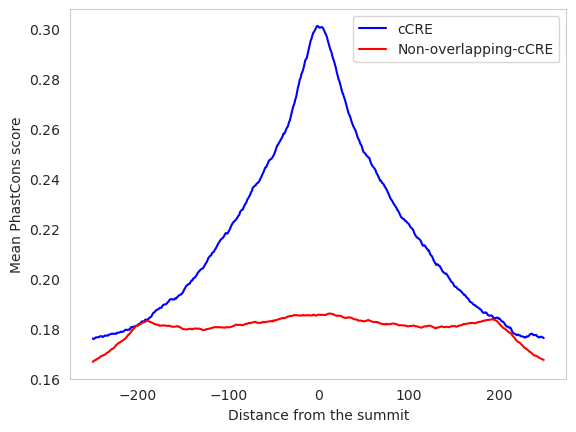

In [179]:
x = np.arange(-250, 250)
plt.plot(x, mean_value,color='blue', label='cCRE')
plt.plot(x, mean_value_non, color='red', label='Non-overlapping-cCRE')
plt.xlabel('Distance from the summit')
plt.ylabel('Mean PhastCons score')
plt.legend()
plt.grid(visible=False)
plt.show()

